In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Precipitation Analysis

In [9]:
#Get the column names for Measurement table
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

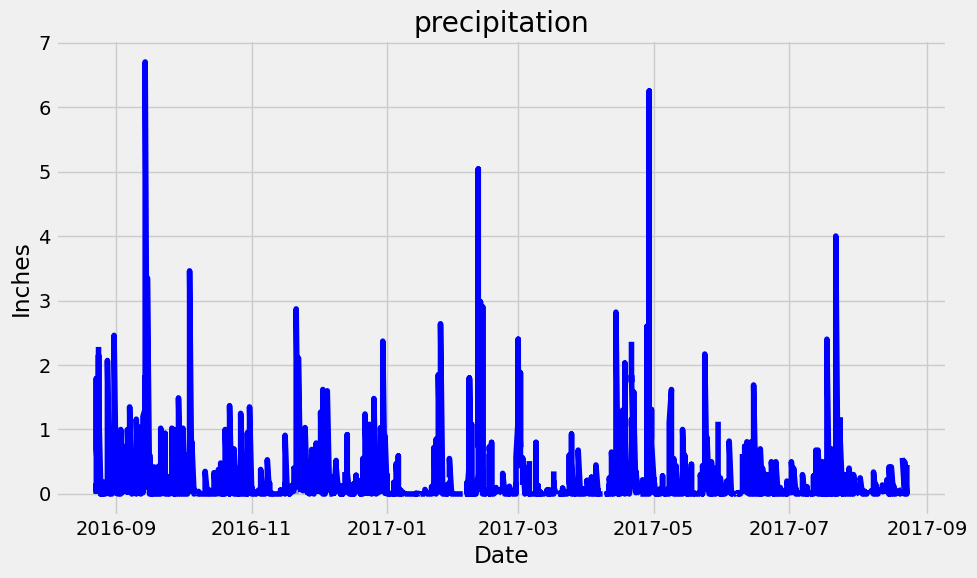

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date = dt.datetime.strptime(recent_date[0], '%Y-%m-%d').date()

# Calculate the date one year from the last date in data set.
one_yr_prior = recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores and sort by date
prcp_scores = session.query(Measurement.date, Measurement.prcp). \
            filter(Measurement.date >= one_yr_prior).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df=pd.DataFrame(prcp_scores, columns =['Date', 'Precipitation'])
prcp_df['Date'] = pd.to_datetime(prcp_df['Date'])

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title("precipitation")
plt.plot(prcp_df['Date'], prcp_df['Precipitation'], color='b')

plt.tight_layout()
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,Date,Precipitation
count,2230,2021.000000
mean,2017-02-16 05:31:15.874439424,0.177279
min,2016-08-23 00:00:00,0.000000
25%,2016-11-18 00:00:00,0.000000
50%,2017-02-14 12:00:00,0.020000
75%,2017-05-17 00:00:00,0.130000
max,2017-08-23 00:00:00,6.700000
std,NaN,0.461190


# Exploratory Station Analysis

In [13]:
columns_s = inspector.get_columns('Station')
for c in columns_s:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
# Design a query to calculate the total number of stations in the dataset
session.query(Station.station).count()

9

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?) 
# List the stations and their counts in descending order.
station_counts = (
    session.query(Measurement.station, func.count(Measurement.station).label('count'))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)

# Display the results
for station, count in station_counts:
    print(f"{station}, {count}")


USC00519281, 2772
USC00519397, 2724
USC00513117, 2709
USC00519523, 2669
USC00516128, 2612
USC00514830, 2202
USC00511918, 1979
USC00517948, 1372
USC00518838, 511


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_stats = (
    session.query(
        func.min(Measurement.tobs).label("lowest_temp"),
        func.avg(Measurement.tobs).label("avg_temp"),
        func.max(Measurement.tobs).label("highest_temp")
    )
    .filter(Measurement.station == "USC00519281")
    .first()
)
lowest_temp = temp_stats.lowest_temp
avg_temp = temp_stats.avg_temp
highest_temp = temp_stats.highest_temp
print(f"{lowest_temp}, {highest_temp},{avg_temp}")

54.0, 85.0,71.66378066378067


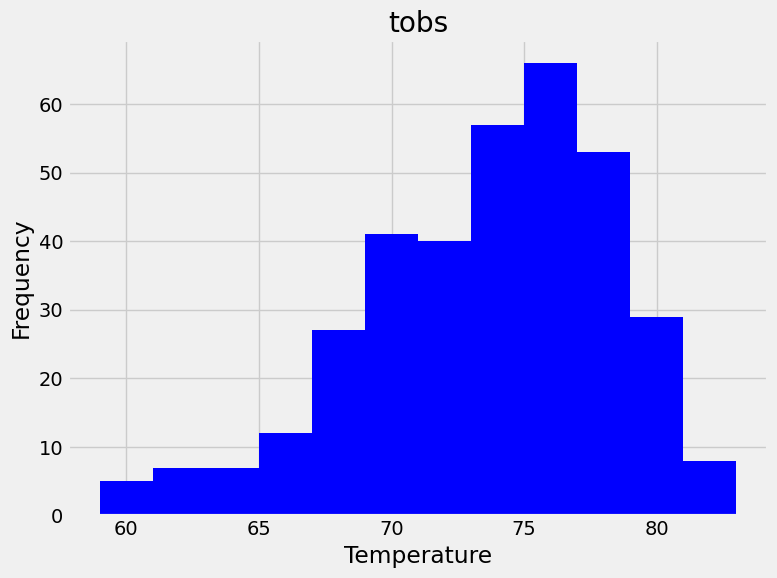

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

station_id = "USC00519281"
temp_data = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == station_id)
    .filter(Measurement.date >= one_yr_prior)
    .all()
)

# Extract temperatures into a list
temperatures = [temp[0] for temp in temp_data]

# Plot the results as a histogram
plt.figure(figsize=(8, 6))  
plt.hist(temperatures, bins=12, color='blue')
plt.title("tobs")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


# Close Session

In [18]:
# Close Session
session.close()